## Урок 1. Введение в PyTorch

In [2]:
# !pip3 install torch torchvision
# !pip3 show torch
# !pip3 show torchvision
# !nvcc --version

Name: torch
Version: 1.7.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\users\alexander\anaconda3\lib\site-packages
Requires: typing-extensions, numpy
Required-by: torchvision


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

In [11]:
def print_tens_info(tensor):
    print("X :\n%s\n" % tensor)
    print("X количество измерений:\n%s\n" % tensor.dim())
    print("X размеры : ",  tensor.size())
    print("X тип : %s\n" % (tensor.type()))
    print("Добавим 10 :\n%s\n" % (tensor + 10))
#     print("Среднее по строчке :\n%s\n" % (tensor.mean(axis=-1)))
#     print("Среднее по столбцу :\n%s\n" % (tensor.mean(axis=0)))

## Домашнее задание: 

### 1. Добиться вразумительного результата от модели, собранной на занятии (7 угаданныx картинок из 10 предложенных на семинаре). 
Варианты изменений:  
- изменение слоёв и их количества;
- изменение метода оптимизации; 
- изменение процесса обучения; 
- для продвинутых: преобразование данных transform  

#### Загрузка данных и формирование датасетов

In [242]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_dataset = torchvision.datasets.CIFAR10(
    root='../data/', # путь куда будут скачиваться наши данные(если download=true), 
                        # или где лежат наши данные(dowload=False)
    train=True, # говорим что используем датасет для обучения  
    transform=transforms.ToTensor(), # важная строчка: здесь мы преобразуем данные
                                    # из датасета в формат тензоров из торч
    download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(
    root='../data', 
    train=False,
    download=False, 
    transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10,
                                          shuffle=False)

torch.Size([3, 32, 32])
truck


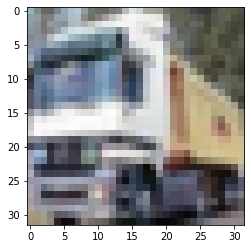

In [240]:
image, label = train_dataset[1]
print (image.size())
print (classes[label])

plt.imshow(image.permute(1, 2, 0).numpy())

#### Инициализация параметров сети

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pred = self.fc3(x)
        return pred

In [246]:
# net = Net().to('cuda')
net = Net()

In [247]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Обучение

In [248]:
for epoch in range(10):  # 10 эпох 
    running_loss = 0.0 # Для вывода процесса обучения
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # Обнуляем градиент
        optimizer.zero_grad()
    
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

[1,     1] loss: 0.001


KeyboardInterrupt: 

#### Сохранение и загрузка модели

In [74]:
PATH = './cifar_net_version_test_intro.pth'
torch.save(net.state_dict(), PATH)

In [75]:
print("Model state_dict: ")
for param in net.state_dict():
    print(param," \ ", net.state_dict()[param].size())

Model state_dict: 
conv1.weight  \  torch.Size([6, 3, 5, 5])
conv1.bias  \  torch.Size([6])
conv2.weight  \  torch.Size([16, 6, 5, 5])
conv2.bias  \  torch.Size([16])
fc1.weight  \  torch.Size([120, 400])
fc1.bias  \  torch.Size([120])
fc2.weight  \  torch.Size([84, 120])
fc2.bias  \  torch.Size([84])
fc3.weight  \  torch.Size([10, 84])
fc3.bias  \  torch.Size([10])


In [223]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Тестирование модели

In [232]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

        cat       ship       ship      plane       frog       frog        car       frog        cat        car


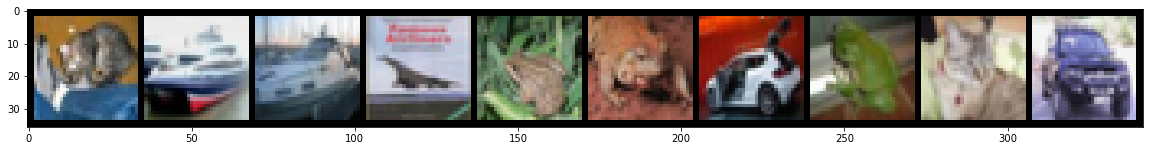

In [225]:
outputs = net(images)
plt.figure(figsize=[20, 20])
imgs = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('     ', '      '.join('%5s' % classes[labels[j]] for j in range(10)))

In [165]:
_, predicted = torch.max(outputs, 1)

preds = [classes[predicted[j]] for j in range(10)]

print('Predicted: ', ' '.join('%5s' % p for p in preds))

Predicted:    dog  ship   car  ship  frog  frog   car  frog  bird   car


In [193]:
table = pd.DataFrame(list(zip([classes[l] for l in labels], preds)), columns=['class', 'pred'])

In [213]:
def style_specific_cell(x):
    
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    for index, row in table.iterrows():
        color = f"background-color: {'lightgreen' if row['class'] == row['pred'] else 'red'}"
        df.iloc[index, 1] = color
            
    return df

def calc_prec(df):
    precision = 0
    for index, row in df.iterrows():
        if row['class'] == row['pred']:
            precision += 1

    return precision / df.shape[0] * 100

In [214]:
table.style.apply(style_specific_cell, axis=None)

,class,pred
0,cat,dog
1,ship,ship
2,ship,car
3,plane,ship
4,frog,frog
5,frog,frog
6,car,car
7,frog,frog
8,cat,bird
9,car,car


In [218]:
print(f'precision = {calc_prec(table)} %')

precision = 60.0 %


In [249]:
steps = [0.005, 0.001, 0.0005]
momentums = [0.85, 0.9, 0.95]
epoches = [8, 10, 12]

In [252]:
print('step\tmomen\tepoch\tprec')

for s in steps:
    for m in momentums:
        for e in epoches:            

            net = Net()

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(net.parameters(), lr=s, momentum=m)

            for epoch in range(e):  # 10 эпох 
                running_loss = 0.0 # Для вывода процесса обучения
                for i, data in enumerate(train_loader, 0):
                    inputs, labels = data[0], data[1]
                    
                    optimizer.zero_grad()
                    out = net(inputs)
                    loss = criterion(out, labels)
                    loss.backward()
                    optimizer.step()
                  
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            preds = [classes[predicted[j]] for j in range(10)]

            table = pd.DataFrame(list(zip([classes[l] for l in labels], preds)), columns=['class', 'pred'])

            print(f'{s}\t{m}\t{e}\t{calc_prec(table)}')

step	momen	epoch	prec
0.005	0.85	8	20.0
0.005	0.85	10	0.0
0.005	0.85	12	10.0
0.005	0.9	8	0.0
0.005	0.9	10	0.0
0.005	0.9	12	10.0
0.005	0.95	8	10.0
0.005	0.95	10	0.0
0.005	0.95	12	10.0
0.001	0.85	8	0.0
0.001	0.85	10	10.0
0.001	0.85	12	10.0
0.001	0.9	8	0.0
0.001	0.9	10	20.0
0.001	0.9	12	0.0
0.001	0.95	8	30.0
0.001	0.95	10	20.0
0.001	0.95	12	20.0
0.0005	0.85	8	20.0
0.0005	0.85	10	20.0
0.0005	0.85	12	10.0
0.0005	0.9	8	20.0
0.0005	0.9	10	10.0
0.0005	0.9	12	10.0
0.0005	0.95	8	10.0
0.0005	0.95	10	0.0
0.0005	0.95	12	0.0


### 2. Переписать данный туториал на pytorch: 
https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

#### Краткое руководство по TensorFlow 2 для начинающих

##### Импорт необходимых библиотек

In [ ]:
import torch
import torchvision

In [ ]:
trainset = datasets.MNIST('../data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('../data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)